In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [27]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [28]:
len(words)

32033

In [29]:
chars = [chr(i) for i in range(97, 97 + 26)]
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [30]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [31]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
# kaiming init
# https://pytorch.org/docs/stable/nn.init.html
# ((5/3) / ((n_embed * block_size) ** 0.5))
# we scale W1 by this number which is 0.3
# gain/sqrt(fan_in)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3) / ((n_embed * block_size) ** 0.5))
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # update
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1942
  20000/ 200000: 2.3443
  30000/ 200000: 2.4160
  40000/ 200000: 1.9913
  50000/ 200000: 2.2978
  60000/ 200000: 2.5254
  70000/ 200000: 2.0707
  80000/ 200000: 2.3107
  90000/ 200000: 2.0663
 100000/ 200000: 1.9933
 110000/ 200000: 2.3179
 120000/ 200000: 1.9123
 130000/ 200000: 2.4505
 140000/ 200000: 2.4321
 150000/ 200000: 2.2003
 160000/ 200000: 2.0463
 170000/ 200000: 1.8839
 180000/ 200000: 1.9983
 190000/ 200000: 1.8873


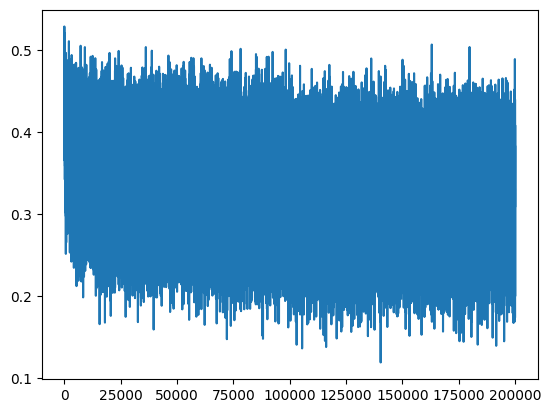

In [33]:
plt.plot(lossi)

In [34]:

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [35]:
bnmean

tensor([[-2.3177e+00, -3.6405e-01, -1.0247e+00,  1.2613e+00,  1.7141e+00,
          1.0201e+00,  1.9386e+00, -2.2117e+00, -1.2373e-01,  1.3685e-01,
         -1.7104e+00, -1.9277e+00, -8.8307e-01,  6.2152e-01, -2.6557e-01,
         -6.3026e-01,  9.8004e-01, -2.2057e+00,  7.8213e-02,  7.9930e-01,
         -5.3766e-01,  2.7581e-01,  6.1362e-01,  1.3937e+00,  7.1978e-01,
          1.2883e+00,  1.4895e+00, -4.1137e-01,  8.4803e-01,  1.8169e+00,
         -2.1954e-01, -1.3686e+00, -7.3394e-01, -1.0650e+00, -2.0063e-01,
         -1.4059e+00, -1.8569e+00,  6.6707e-01, -8.5582e-01,  8.7046e-01,
          6.2614e-02, -4.5244e-01, -4.9262e-01,  5.2697e-01,  1.1893e+00,
          7.7382e-01,  2.7716e+00, -8.7592e-01,  1.5452e+00,  1.3719e+00,
          8.8825e-01, -2.3701e-03,  1.7612e+00,  1.3297e+00,  9.8161e-01,
         -1.8443e+00, -1.6664e-01,  6.6285e-01,  2.0306e+00, -2.8664e+00,
         -4.7367e-01,  5.8872e-01,  7.6725e-02,  6.2640e-01,  2.2088e+00,
          1.2394e+00, -3.6636e-01,  1.

In [36]:
bnmean_running

tensor([[-2.3445e+00, -3.5034e-01, -1.0127e+00,  1.2629e+00,  1.7157e+00,
          1.0085e+00,  1.9285e+00, -2.2175e+00, -1.2663e-01,  1.3021e-01,
         -1.7290e+00, -1.9392e+00, -8.8938e-01,  6.0991e-01, -2.6687e-01,
         -6.0494e-01,  9.8814e-01, -2.2140e+00,  6.0801e-02,  7.7775e-01,
         -5.3136e-01,  2.8867e-01,  6.0593e-01,  1.3920e+00,  7.1696e-01,
          1.2922e+00,  1.5023e+00, -4.1435e-01,  8.3973e-01,  1.8148e+00,
         -2.3546e-01, -1.3639e+00, -7.2678e-01, -1.0638e+00, -1.9583e-01,
         -1.4107e+00, -1.8722e+00,  6.5585e-01, -8.4154e-01,  8.7341e-01,
          4.7281e-02, -4.7718e-01, -4.9639e-01,  5.2343e-01,  1.2032e+00,
          7.9042e-01,  2.7750e+00, -8.7955e-01,  1.5351e+00,  1.3743e+00,
          8.7428e-01, -8.4366e-03,  1.7559e+00,  1.3274e+00,  9.8032e-01,
         -1.8463e+00, -1.6473e-01,  6.5882e-01,  2.0455e+00, -2.8682e+00,
         -4.9856e-01,  5.8613e-01,  6.3064e-02,  6.2298e-01,  2.2022e+00,
          1.2326e+00, -3.7524e-01,  1.

In [37]:
bnstd

tensor([[2.5774, 2.0526, 2.3618, 2.1368, 2.1846, 2.4584, 2.0466, 2.3756, 2.1037,
         2.1399, 2.6536, 2.3401, 2.0661, 2.2608, 2.1886, 2.6695, 2.4102, 1.9025,
         2.3227, 2.2686, 2.1171, 2.4492, 2.2325, 2.2913, 2.2250, 2.1668, 2.2751,
         2.2800, 2.3116, 2.4338, 1.9600, 1.9801, 2.2561, 2.2626, 2.2726, 2.3296,
         4.0039, 2.3622, 2.9114, 1.9598, 2.0984, 2.1730, 2.3465, 2.1367, 2.3041,
         2.5543, 2.1177, 2.7289, 2.1559, 2.6261, 2.1664, 2.0403, 2.1289, 1.9327,
         2.1018, 2.3091, 2.0403, 2.1755, 2.9706, 1.8855, 2.1296, 2.1919, 2.0179,
         2.2901, 2.3282, 2.1779, 2.0830, 2.5356, 2.2903, 2.2408, 2.3152, 2.0731,
         1.9556, 2.2118, 1.9390, 1.8939, 2.5302, 2.5021, 1.9014, 2.1166, 2.3604,
         2.1534, 2.1011, 2.2480, 2.6945, 2.3391, 2.0747, 2.4778, 2.4693, 2.6975,
         2.0789, 2.0609, 2.3381, 2.1191, 2.2821, 2.2375, 2.2179, 2.0186, 1.9854,
         2.1641, 1.9188, 2.2278, 2.0187, 2.1472, 2.0475, 2.2218, 2.0836, 2.2195,
         2.1102, 2.2886, 2.2

In [38]:
bnstd_running

tensor([[2.5580, 2.0259, 2.3437, 2.0971, 2.1464, 2.4192, 2.0358, 2.3379, 2.0753,
         2.1125, 2.6360, 2.3071, 2.0328, 2.2406, 2.1564, 2.6491, 2.3797, 1.8880,
         2.2961, 2.2555, 2.0928, 2.4227, 2.2089, 2.2715, 2.1994, 2.1408, 2.2422,
         2.2530, 2.2899, 2.3981, 1.9297, 1.9795, 2.2543, 2.2400, 2.2635, 2.3003,
         3.9886, 2.3289, 2.8939, 1.9369, 2.0768, 2.1449, 2.3070, 2.1090, 2.2740,
         2.5338, 2.0946, 2.6711, 2.1303, 2.6143, 2.1326, 2.0205, 2.1046, 1.9140,
         2.0781, 2.2856, 2.0190, 2.1540, 2.9517, 1.8699, 2.1071, 2.1764, 2.0069,
         2.2686, 2.3052, 2.1526, 2.0627, 2.5060, 2.2668, 2.2101, 2.2896, 2.0534,
         1.9384, 2.1881, 1.9209, 1.8762, 2.5127, 2.4779, 1.8812, 2.1026, 2.3317,
         2.1260, 2.0704, 2.2261, 2.6732, 2.2952, 2.0393, 2.4467, 2.4558, 2.6842,
         2.0571, 2.0345, 2.3218, 2.0948, 2.2767, 2.2084, 2.1994, 2.0006, 1.9556,
         2.1482, 1.9117, 2.2045, 1.9926, 2.1346, 2.0226, 2.1964, 2.0625, 2.1777,
         2.0909, 2.2477, 2.2

In [39]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.078073024749756
val 2.1128151416778564


In [40]:
# sample from the model
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1, block_size, n_embed)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
      h = torch.tanh(hpreact)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahza.
jahmelik.
mri.
reity.
salaysie.
mahnen.
den.
art.
kaeli.
nellara.
chaiivon.
leigh.
ham.
jore.
quinthonor.
marianni.
watell.
dearyni.
jace.
pius.
